In [21]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field

In [7]:
model = ChatOllama(model='llama3.2')

model1 = ChatOllama(model='llama3.2')
model2 = ChatOllama(model='deepseek-r1')
model3 = ChatOllama(model="gemma3")

In [42]:
class OrchState(TypedDict):
    '''Orchestration states defined for the workflow'''
    user_input: Annotated[str, "Natural language intent"]
    parsed_tasks: Annotated[list, "Structured list of tasks"]
    intent_evaluation: Literal["approved", "needs_improvement"]
    execution_log: Annotated[list, "Logs of each task"]
    int_iteration: Annotated[str, "Natural language intent evaluation iterations"]
    int_max_iteration: Annotated[str, "Natural language intent evaluation max iterations"]


In [22]:
class ParserStructure(BaseModel):
    intent_parser: list = Field(..., description="Parse user intent in structured form")

In [33]:
def parse_intent(state: OrchState) -> OrchState:
    user_input = state["user_input"]
    prompt = f"Convert user request into task list. \nUser wants: {user_input}"
    structured_model = model.with_structured_output(ParserStructure)
    parsed = structured_model.invoke(prompt).intent_parser
    # print("Before User Input Parsed",parsed)
    # state["parsed_tasks"] = eval(parsed)  # use ast.literal_eval in production
    print("After User Input Parsed",parsed)
    return state

In [ ]:
def route_evaluation(state: OrchState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['int_max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [34]:
def execute_tasks(state: OrchState) -> OrchState:
    tasks = state["parsed_tasks"]
    logs = []
    for task in tasks:
        # Simulate task execution
        logs.append(f"Executed task: {task['type']} with {task.get('details', {})}")
    state["execution_log"] = logs
    return state

In [35]:
graph = StateGraph(OrchState)

graph.add_node("ParseIntent", parse_intent)
graph.add_node("ExecuteWorkflow", execute_tasks)

graph.set_entry_point("ParseIntent")
graph.add_edge("ParseIntent", "ExecuteWorkflow")
graph.set_finish_point("ExecuteWorkflow")

workflow = graph.compile()

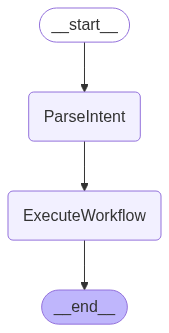

In [36]:
workflow

In [38]:
initial_state = {
    "user_input": "When a new row is added to a Google Sheet, send me an email notification.",
    "parsed_tasks": [],
    "execution_log": []
}

final_state = workflow.invoke(initial_state)

print("Parsed Tasks:", final_state["parsed_tasks"])
print("Execution Log:", final_state["execution_log"])

After User Input Parsed [{'task_list': [{'description': 'Configure Google API Service account credentials for notification', 'steps': [{'text': ''}, {'type': 'step', 'title': 'Create a service account in the G Suite Admin Console', 'text': 'Navigate to the G Suite Admin Console and create a new service account'}, {'type': 'step', 'title': 'Generate a private key for the service account', 'text': 'Download the JSON key file and save it securely'}]}, {'description': 'Configure Google Apps Script to send notifications via email', 'steps': [{'text': ''}, {'type': 'step', 'title': 'Create a new script in your Google Sheet', 'text': 'Go to the script editor and create a new function to handle the notification'}, {'type': 'step', 'title': 'Configure the trigger to send an email when a new row is added', 'text': 'Use the `onInsert` trigger to send an email when a new row is inserted'}]}, {'description': 'Test and deploy the notification script', 'steps': [{'text': ''}, {'type': 'step', 'title'

In [44]:
from typing import TypedDict
import uuid
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph

from langgraph.types import interrupt, Command


class State(TypedDict):
    some_text: str


def human_node(state: State):
    value = interrupt(  
        {
            # "text_to_revise": state["some_text"]  
            "text_to_revise": input("edit it")  

        }
    )
    return {
        "some_text": value  
    }


# Build the graph
graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")
checkpointer = InMemorySaver()  
graph = graph_builder.compile(checkpointer=checkpointer)
# Pass a thread ID to the graph to run it.
config = {"configurable": {"thread_id": uuid.uuid4()}}
# Run the graph until the interrupt is hit.
result = graph.invoke({"some_text": "original text"}, config=config)  

print(result['__interrupt__']) 
# > [
# >    Interrupt(
# >       value={'text_to_revise': 'original text'},
# >       resumable=True,
# >       ns=['human_node:6ce9e64f-edef-fe5d-f7dc-511fa9526960']
# >    )
# > ]
print(result["__interrupt__"])  
# > [Interrupt(value={'text_to_revise': 'original text'}, id='6d7c4048049254c83195429a3659661d')]

print(graph.invoke(Command(resume="Edited text"), config=config)) 
# > {'some_text': 'Edited text'}

[Interrupt(value={'text_to_revise': 'hi'}, id='dbf897a10a7e0ca06d8e941b496b5898')]
[Interrupt(value={'text_to_revise': 'hi'}, id='dbf897a10a7e0ca06d8e941b496b5898')]
{'some_text': 'Edited text'}
